In [1]:

import numpy as np
import keras
from keras.layers import *
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from matplotlib import pyplot as plt
dtype_global =tf.float64

In [6]:
number_of_classes = 2

model = keras.Sequential([
    keras.layers.Input(shape=(81, 65)),
    Conv1D(filters=64, kernel_size=3, activation="gelu", padding="same"),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    Conv1D(filters=48, kernel_size=3, activation="gelu", padding="same"),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    Conv1D(filters=32, kernel_size=3, activation="gelu", padding="same"),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    Bidirectional(LSTM(512, activation='tanh', return_sequences=True)),
    MaxPooling1D(pool_size=2, strides=2, padding="same"),
    BatchNormalization(),
    Dropout(0.2),
    TimeDistributed(Dense(64,activation='gelu')),
    TimeDistributed(Dense(32,activation='gelu')),
    TimeDistributed(Dense(16,activation='gelu')),
    TimeDistributed(Dense(8,activation='gelu')),
    Flatten(),
    Dense(number_of_classes,activation='gelu')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 81, 64)            12544     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 41, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 41, 48)            9264      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 21, 48)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 32)            4640      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 11, 32)           

In [7]:
train_spectrogram_ds = tf.data.experimental.load(
    'data/tf/train.ds', element_spec=None, compression=None, reader_func=None
)

val_spectrogram_ds = tf.data.experimental.load(
    'data/tf/val.ds', element_spec=None, compression=None, reader_func=None
)

test_spectrogram_ds = tf.data.experimental.load(
    'data/tf/test.ds', element_spec=None, compression=None, reader_func=None
)



train_spectrogram_ds.map(lambda x, y: (tf.cast(x, dtype=dtype_global), y))
train_spectrogram_ds = train_spectrogram_ds.unbatch().filter(lambda x, y: y == 0 or y == 1).batch(64)

val_spectrogram_ds.map(lambda x, y: (tf.cast(x, dtype=dtype_global), y))
val_spectrogram_ds = val_spectrogram_ds.unbatch().filter(lambda x, y: y == 0 or y == 1).batch(64)

test_spectrogram_ds.map(lambda x, y: (tf.cast(x, dtype=dtype_global), y))
test_spectrogram_ds = test_spectrogram_ds.unbatch().filter(lambda x, y: y == 0 or y == 1).batch(64)

train_spectrogram_ds = train_spectrogram_ds
val_spectrogram_ds = val_spectrogram_ds
test_spectrogram_ds = test_spectrogram_ds


checkpoint_filepath = 'quantum/checkpoints/asr/lstm/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



In [8]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.EarlyStopping(verbose=1, patience=2), model_checkpoint_callback],
)


Epoch 1/20
23/23 [==============================] - 4s 68ms/step - loss: 0.6174 - accuracy: 0.6564 - val_loss: 0.6674 - val_accuracy: 0.6182
Epoch 2/20
23/23 [==============================] - 1s 41ms/step - loss: 0.4680 - accuracy: 0.7868 - val_loss: 0.6455 - val_accuracy: 0.6757
Epoch 3/20
23/23 [==============================] - 1s 35ms/step - loss: 0.3525 - accuracy: 0.8429 - val_loss: 0.6438 - val_accuracy: 0.6622
Epoch 4/20
23/23 [==============================] - 1s 39ms/step - loss: 0.2984 - accuracy: 0.8527 - val_loss: 0.6151 - val_accuracy: 0.7601
Epoch 5/20
23/23 [==============================] - 1s 37ms/step - loss: 0.2511 - accuracy: 0.8850 - val_loss: 0.5943 - val_accuracy: 0.7804
Epoch 6/20
23/23 [==============================] - 1s 37ms/step - loss: 0.2158 - accuracy: 0.9109 - val_loss: 0.5670 - val_accuracy: 0.8277
Epoch 7/20
23/23 [==============================] - 1s 34ms/step - loss: 0.2165 - accuracy: 0.9102 - val_loss: 0.5405 - val_accuracy: 0.7264
Epoch 8/20
23

Text(0, 0.5, 'Accuracy [%]')

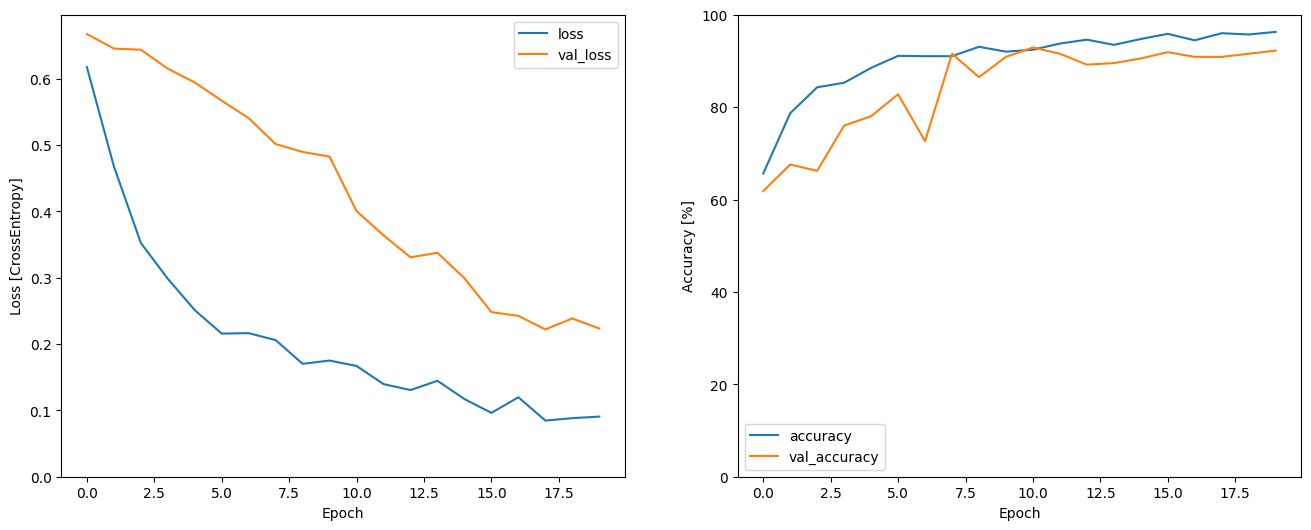

In [10]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [11]:
model.evaluate(test_spectrogram_ds, return_dict=True)

5/5 [==============================] - 0s 13ms/step - loss: 0.2830 - accuracy: 0.8849


{'loss': 0.2829866111278534, 'accuracy': 0.8848921060562134}